# Chapter 6: Multiple Linear Regression

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [1]:
import seaborn as sns
import numpy as np
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

no display found. Using non-interactive Agg backend


In [6]:
car_df = pd.read_csv('../ToyotaCorolla.csv')

In [18]:
car_df.columns

Index(['Id', 'Model', 'Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM',
       'Fuel_Type', 'HP', 'Met_Color', 'Color', 'Automatic', 'CC', 'Doors',
       'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee',
       'BOVAG_Guarantee', 'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2',
       'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player',
       'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio',
       'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
       'Radio_cassette', 'Parking_Assistant', 'Tow_Bar'],
      dtype='object')

In [7]:
predictors = ['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 
              'Doors', 'Quarterly_Tax', 'Weight']
outcome = 'Price'

In [8]:
car_df.shape

(1436, 39)

# Exploratory Data Analysis (EDA)

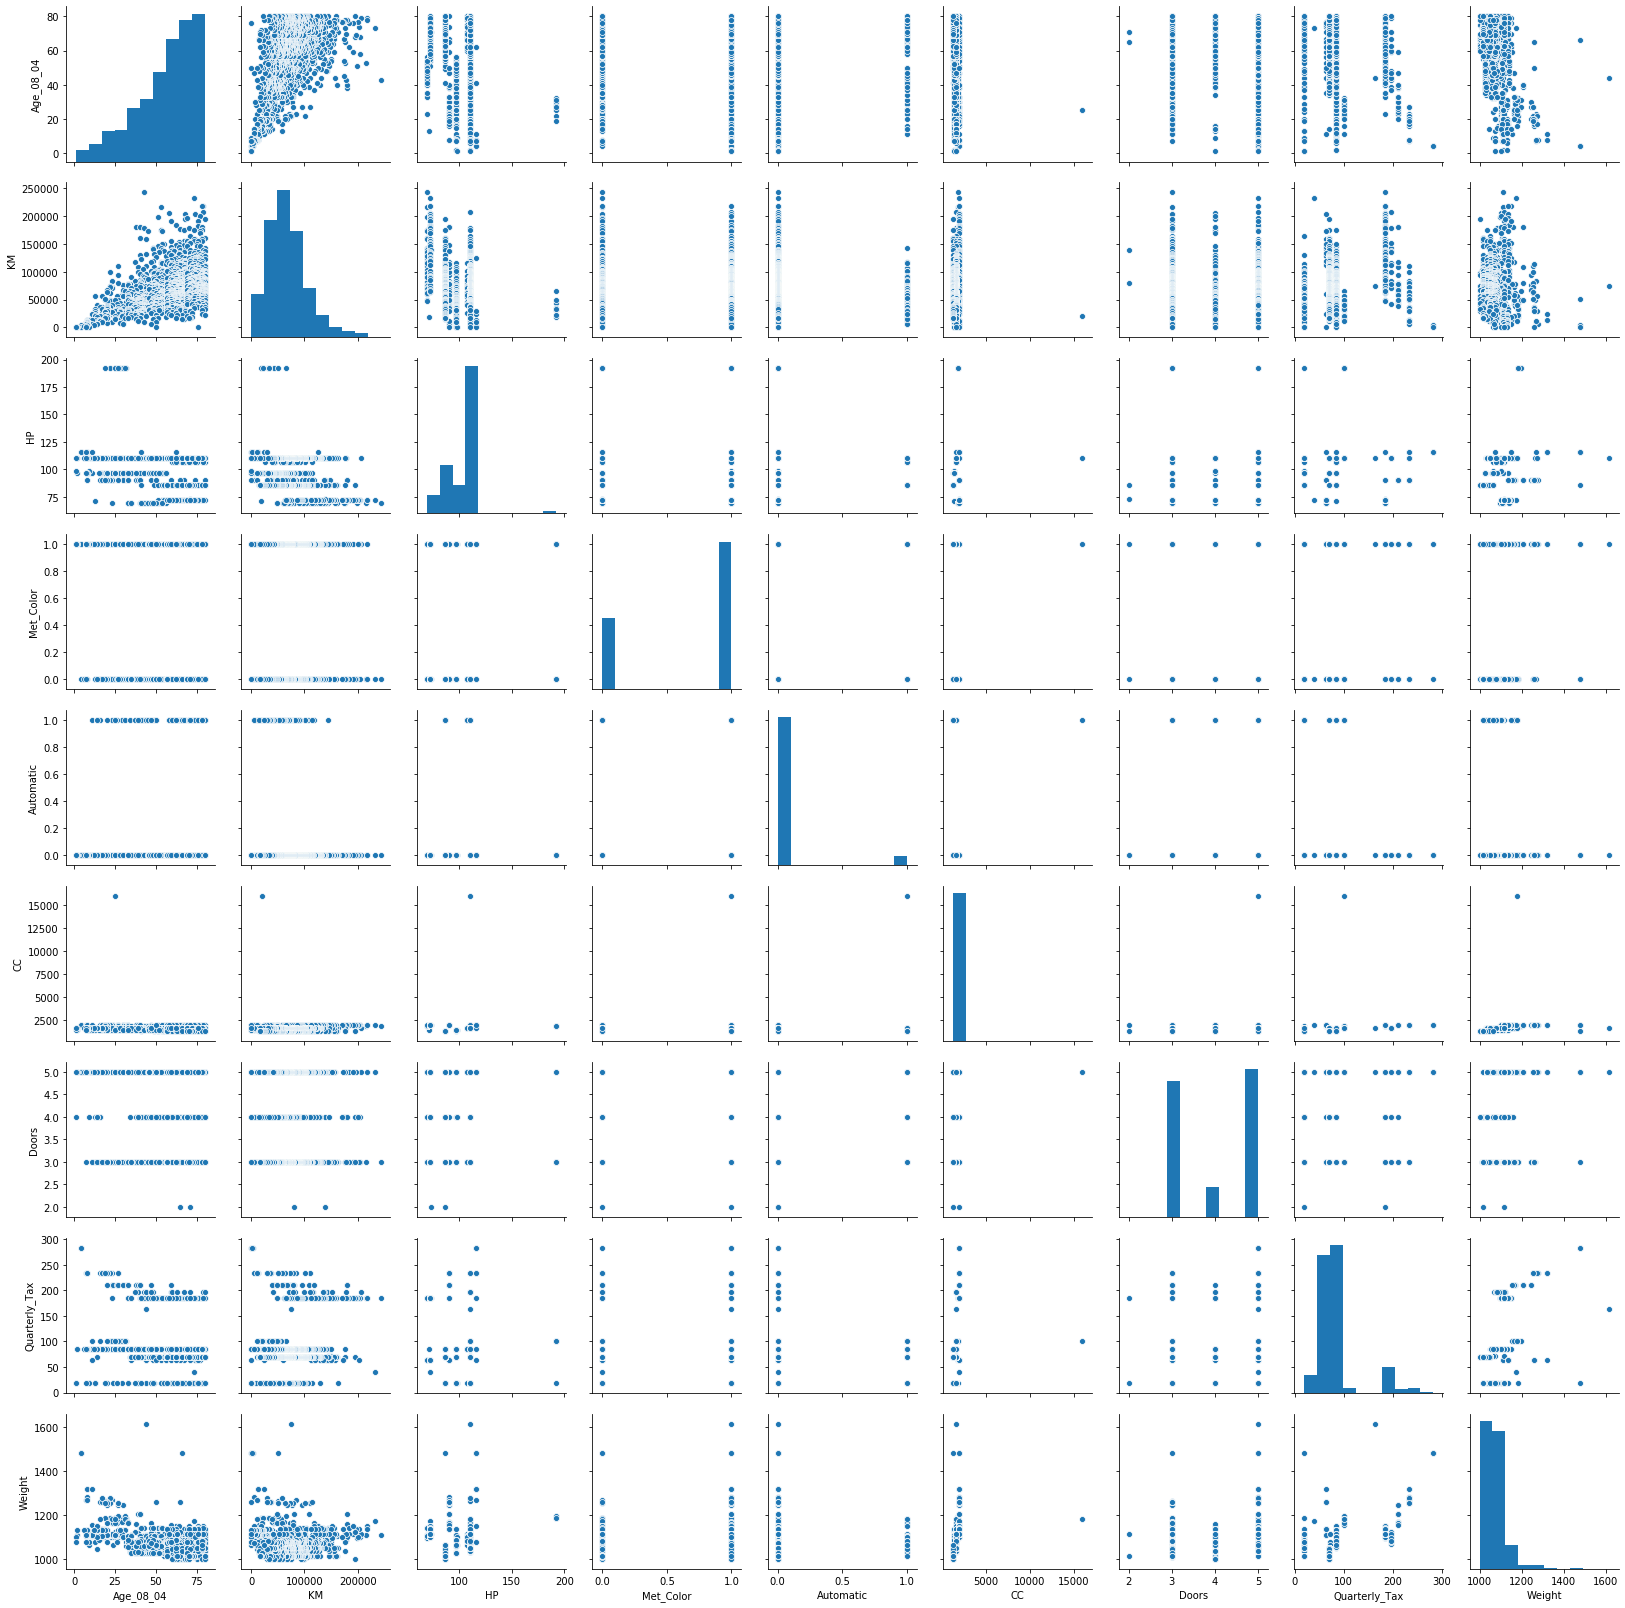

In [10]:
%matplotlib inline
sns.pairplot(car_df[predictors])

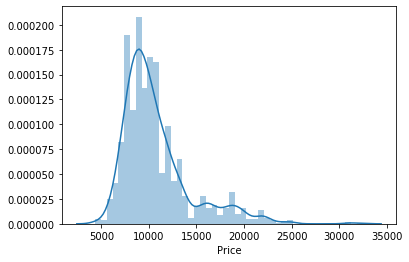

In [11]:
sns.distplot(car_df['Price'])

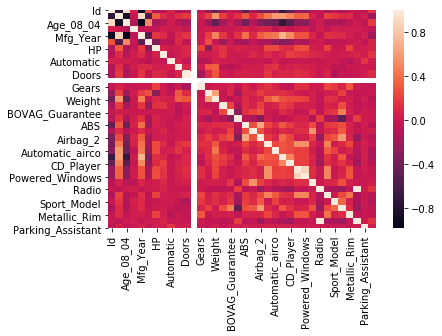

In [12]:
sns.heatmap(car_df.corr())

## Table 6.3 dummy-code categorical variable 

In [42]:
#reduce data frame to the top 1000 rows and select columns for regression analysis
car_df = pd.read_csv('../ToyotaCorolla.csv')
car_df = car_df.iloc[0:1000]

In [43]:
car_df.shape

(1000, 39)

In [44]:
car_df['Fuel_Type'].value_counts()

Petrol    867
Diesel    119
CNG        14
Name: Fuel_Type, dtype: int64

In [45]:
# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]

In [46]:
X.shape

(1000, 11)

In [47]:
X.columns

Index(['Age_08_04', 'KM', 'HP', 'Met_Color', 'Automatic', 'CC', 'Doors',
       'Quarterly_Tax', 'Weight', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol'],
      dtype='object')

In [48]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1) #this comes from the sklearn.model_selection import

car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

coeff_df = pd.DataFrame(car_lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Age_08_04,-140.748761
KM,-0.017840
HP,36.103419
Met_Color,84.281830
Automatic,416.781954
CC,0.017737
Doors,-50.657863
Quarterly_Tax,13.625325
Weight,13.038711
Fuel_Type_Diesel,1066.464681


In [49]:
# print the intercept
print(car_lm.intercept_)

-1319.3543800411808


Price = -258.60 - 124.11 x Age_08_04 + ... + 2413.06 x Fuel_Type_Petrol



### Predictions from our Model

Let's the predictions on our test *(unseen or hold-out)* set to see how well the model did on 'unseen' data

In [50]:
car_lm_predicted = car_lm.predict(valid_X)

(0, 26365.077525683744)

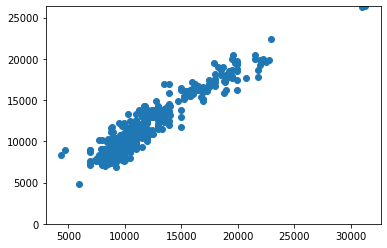

In [51]:
plt.scatter(valid_y,car_lm_predicted)
plt.ylim(0, max(car_lm_predicted))

## Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

In [52]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(valid_y, car_lm_predicted))
print('MSE:', metrics.mean_squared_error(valid_y, car_lm_predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(valid_y, car_lm_predicted)))

MAE: 1017.5971544783306
MSE: 1723581.0830504773
RMSE: 1312.8522700785786


## Table 6.4

In [53]:
car_lm_pred = car_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': car_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - car_lm_pred})
print(result.head(20))

        Predicted  Actual     Residual
507  10607.333940   11500   892.666060
818   9272.705792    8950  -322.705792
452  10617.947808   11450   832.052192
368  13600.396275   11450 -2150.396275
242  12396.694660   11950  -446.694660
929   9496.498212    9995   498.501788
262  12480.063217   13500  1019.936783
810   8834.146068    7950  -884.146068
318  12183.361282    9900 -2283.361282
49   19206.965683   21950  2743.034317
446  10987.498309   11950   962.501691
142  18501.527375   19950  1448.472625
968   9914.690947    9950    35.309053
345  13827.299932   14950  1122.700068
971   7966.732543   10495  2528.267457
133  17185.242041   15950 -1235.242041
104  19952.658062   19450  -502.658062
6    16570.609280   16900   329.390720
600  13739.409113   11250 -2489.409113
496  11267.513740   11750   482.486260


In [55]:
# Compute common accuracy measures
regressionSummary(valid_y, car_lm_pred)


Regression statistics

                      Mean Error (ME) : 103.6803
       Root Mean Squared Error (RMSE) : 1312.8523
            Mean Absolute Error (MAE) : 1017.5972
          Mean Percentage Error (MPE) : -0.2633
Mean Absolute Percentage Error (MAPE) : 9.0111


## Figure 6.1
Determine the residuals and create a histogram

0.7425


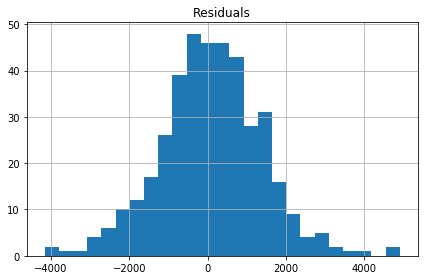

In [56]:
car_lm_pred = car_lm.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

In [ ]:
#End Week 5

# Appendix - Regularized methods

In [57]:
lasso = Lasso(normalize=True, alpha=1)
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))

lasso_cv = LassoCV(normalize=True, cv=5)
lasso_cv.fit(train_X, train_y)
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print('Lasso-CV chosen regularization: ', lasso_cv.alpha_)
print(lasso_cv.coef_)

ridge = Ridge(normalize=True, alpha=1)
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))

bayesianRidge = BayesianRidge(normalize=True)
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
print('Bayesian ridge chosen regularization: ', bayesianRidge.lambda_ / bayesianRidge.alpha_)


Regression statistics

                      Mean Error (ME) : 120.6311
       Root Mean Squared Error (RMSE) : 1332.2752
            Mean Absolute Error (MAE) : 1021.5286
          Mean Percentage Error (MPE) : -0.2364
Mean Absolute Percentage Error (MAPE) : 9.0115

Regression statistics

                      Mean Error (ME) : 145.1571
       Root Mean Squared Error (RMSE) : 1397.9428
            Mean Absolute Error (MAE) : 1052.4649
          Mean Percentage Error (MPE) : -0.2966
Mean Absolute Percentage Error (MAPE) : 9.2918
Lasso-CV chosen regularization:  3.5138446691310588
[-1.40370575e+02 -1.76669006e-02  3.38674037e+01  0.00000000e+00
  6.94393427e+01  0.00000000e+00  0.00000000e+00  2.70913468e+00
  1.24342596e+01 -0.00000000e+00  0.00000000e+00]

Regression statistics

                      Mean Error (ME) : 154.3286
       Root Mean Squared Error (RMSE) : 1879.7426
            Mean Absolute Error (MAE) : 1353.2735
          Mean Percentage Error (MPE) : -2.3897
Mean Absolu

In [58]:
linearRegression = LinearRegression(normalize=True).fit(train_X, train_y)
regressionSummary(valid_y, linearRegression.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 103.6803
       Root Mean Squared Error (RMSE) : 1312.8523
            Mean Absolute Error (MAE) : 1017.5972
          Mean Percentage Error (MPE) : -0.2633
Mean Absolute Percentage Error (MAPE) : 9.0111


In [59]:
pd.DataFrame({'features': train_X.columns, 'linear regression': linearRegression.coef_, 
              'lassoCV': lasso_cv.coef_, 'bayesianRidge': bayesianRidge.coef_})

,features,linear regression,lassoCV,bayesianRidge
0,Age_08_04,-140.748761,-140.370575,-139.754059
1,KM,-0.017840,-0.017667,-0.018131
2,HP,36.103419,33.867404,35.856074
3,Met_Color,84.281830,0.000000,85.088966
4,Automatic,416.781954,69.439343,408.599781
5,CC,0.017737,0.000000,0.020405
6,Doors,-50.657863,0.000000,-47.917629
7,Quarterly_Tax,13.625325,2.709135,13.269979
8,Weight,13.038711,12.434260,13.114412
9,Fuel_Type_Diesel,1066.464681,-0.000000,955.581484


## Table 6.10


In [ ]:
formu

In [64]:
# run a linear regression of Price on the remaining 11 predictors in the training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = 'Price ~ ' + ' + '.join(predictors)

In [66]:
formula

'Price ~ Age_08_04 + KM + HP + Met_Color + Automatic + CC + Doors + Quarterly_Tax + Weight + Fuel_Type_Diesel + Fuel_Type_Petrol'

In [65]:
car_lm = sm.ols(formula=formula, data=train_df).fit()
print(car_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     319.0
Date:                Tue, 29 Sep 2020   Prob (F-statistic):          1.73e-239
Time:                        17:10:46   Log-Likelihood:                -5198.1
No. Observations:                 600   AIC:                         1.042e+04
Df Residuals:                     588   BIC:                         1.047e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1319.3544   1728.427  